# 실습1 - 주문서 정리하기

In [1]:
import pandas as pd
import os
os.chdir(r"C:\Users\진현영\Desktop\패스트캠퍼스\데이터전처리\part-1.-데이터-핸들링\1. 데이터 핸들링\데이터")

## Step 1. 데이터 병합하기

In [5]:
# 시트명 작성하기 : list comprehension
sheet_names = [str(i+1)+'월' for i in range(12)]

In [6]:
# concat이용한 데이터 병합
merged_df = pd.DataFrame()
for sn in sheet_names:
    # 6개 행, 1번째 열 제외하고 불러오기
    df = pd.read_excel("월별매출데이터.xlsx", sheet_name = sn, skiprows = range(6)).iloc[:,1:]
    merged_df = pd.concat([merged_df, df], axis = 0, ignore_index = True) # 충돌방지

In [7]:
merged_df.head()

,일자,지점,품명,수량,주문인 ID,수령 주소,주문 상태,결제 수단
0,2018.1.1,지점1,제품B,3,C-168,서울특별시 동작구 흑석동,주문완료,인터넷뱅킹
1,2018.1.1,지점2,제품F,8,C-87,서울특별시 서대문구 신촌동,배송완료,신용카드
2,2018.1.1,지점4,제품B,2,C-158,서울특별시 종로구 종로5가,배송완료,휴대폰결제
3,2018.1.1,지점3,제품D,7,C-307,서울특별시 서대문구 냉천동,주문완료,휴대폰결제
4,2018.1.1,지점2,제품E,9,C-342,서울특별시 종로구 묘동,배송완료,인터넷뱅킹


In [8]:
merged_df['일자']

0          2018.1.1
1          2018.1.1
2          2018.1.1
3          2018.1.1
4          2018.1.1
            ...    
18224    2018-12-31
18225    2018-12-31
18226    2018-12-31
18227    2018-12-31
18228    2018-12-31
Name: 일자, Length: 18229, dtype: object

## Step 2. 포맷 통일 및 변수 추가
* 날짜 포맷이 혼합되어있어, 포맷을 통일해야 함
* 품명과 수량 컬럼을 바탕으로 주문 금액 계산하여 컬럼 추가

`주문 금액 = 수량 x 가격 x 1.1(부가세)`

In [9]:
# str.replace를 사용하여 '.'을 '-'로 변경
merged_df['일자'] = merged_df['일자'].str.replace('.','-')

In [10]:
price_df = pd.read_excel("제품별_가격정보.xlsx")
price_df # 원활한 분석을 위해 행과 열을 바꿀 필요가 있음

,제품,제품A,제품B,제품C,제품D,제품E,제품F
0,가격,20000,5000,10000,8000,30000,15000


In [11]:
price_df = price_df.T
price_df

,0
제품,가격
제품A,20000
제품B,5000
제품C,10000
제품D,8000
제품E,30000
제품F,15000


In [12]:
price_df.loc['제품A':'제품F', 0]

제품A    20000
제품B     5000
제품C    10000
제품D     8000
제품E    30000
제품F    15000
Name: 0, dtype: object

In [13]:
price_dict = price_df.loc['제품A':'제품F',0].to_dict()  
price_dict

{'제품A': 20000,
 '제품B': 5000,
 '제품C': 10000,
 '제품D': 8000,
 '제품E': 30000,
 '제품F': 15000}

In [14]:
# replace : 품명 컬럼에 price dict의 key가 있으면 value로 바꿈
# 새로운 변수 정의
merged_df['가격'] = merged_df['품명'].replace(price_dict)

In [15]:
# 주문 금액 변수 추가
merged_df['주문 금액'] = merged_df['수량'] * merged_df['가격'] * 1.1 # ndarray 브로드캐스팅

## Step 3. 월별 매출 추이 파악

In [16]:
# 일자 변수에서 월만 추출 (일자가 object므로 월은 int로 바꿔줌)
merged_df['월'] = merged_df['일자'].str.split('-', expand = True).iloc[:, 1].astype(int)

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 20
plt.rcParams["figure.figsize"] = (8, 10)

In [19]:
# 월과 품목에 따른 주문 금액 합계 계산
grouped_df_by_month = merged_df.groupby(['월'],as_index = False)['주문 금액'].sum()
grouped_df_by_month_and_product = merged_df.groupby(['월', '품명'],as_index = False)['주문 금액'].sum()

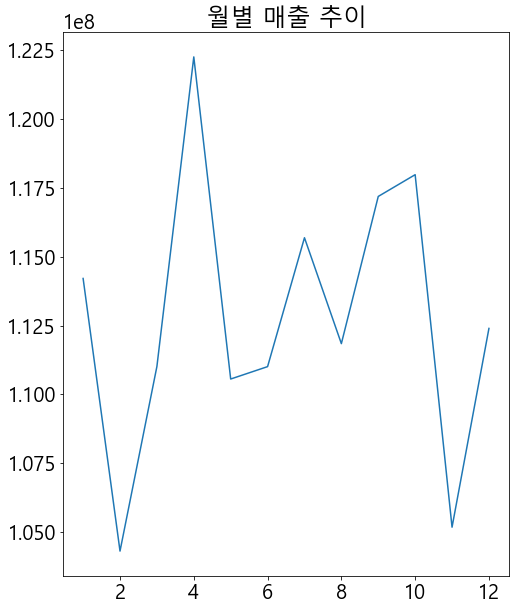

In [22]:
# 첫 번째 그래프 : 제품군에 관계없는 월별 주문 금액 합계
plt.title("월별 매출 추이")
plt.plot(grouped_df_by_month['월'],
         grouped_df_by_month['주문 금액'],
         label = "주문 금액 합계")

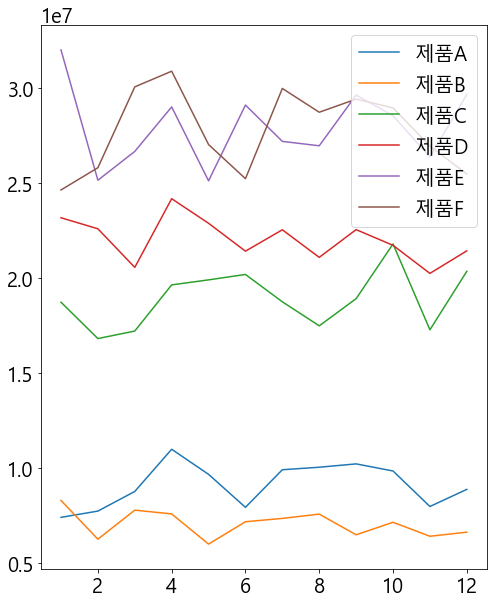

In [23]:
# 두 번째 그래프 : 각 제품에 대한 월별 금액 합계를 따로따로 그리기
# unique쓰는 이유 : group by를 해서 월이 품명개수만큼 있음
for product in grouped_df_by_month_and_product['품명'].unique():
    plt.plot(grouped_df_by_month_and_product['월'].unique(), # 월의 개수가 12*품목 개수인것에 주의
             grouped_df_by_month_and_product.loc[grouped_df_by_month_and_product['품명']==product]['주문 금액'],
             label = product)
    
plt.legend(loc = 'upper right')

## Step 4. 다양한 조건에 따른 판매 통계 분석

<BarContainer object of 6 artists>

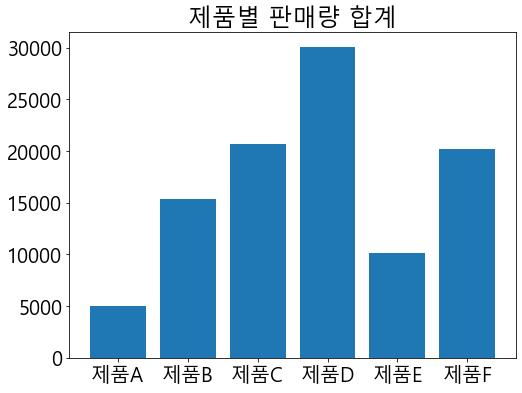

In [24]:
plt.rcParams["figure.figsize"] = (8, 6)

# 제품별 판매량 통계
grouped_df_by_product = merged_df.groupby('품명', as_index = False)['수량'].sum()
plt.title("제품별 판매량 합계")
plt.bar(grouped_df_by_product['품명'], grouped_df_by_product['수량'])

In [29]:
# 제품과 결제 수단에 따른 판매량 분석
pivot_df = pd.pivot_table(merged_df, index = '품명', columns = '결제 수단', values = '주문 금액')
pivot_df

결제 수단,무통장입금,신용카드,인터넷뱅킹,휴대폰결제
품명,,,,
제품A,119044.444444,130730.769231,118383.783784,130149.532710
제품B,31396.678967,30974.603175,31184.294872,30356.589147
제품C,58494.791667,59329.613095,60252.252252,62119.289340
제품D,49949.734513,48474.183351,48494.623656,49720.000000
제품E,188229.050279,184311.897106,186773.607748,200012.195122
제품F,93805.555556,90812.500000,92334.296724,91058.823529


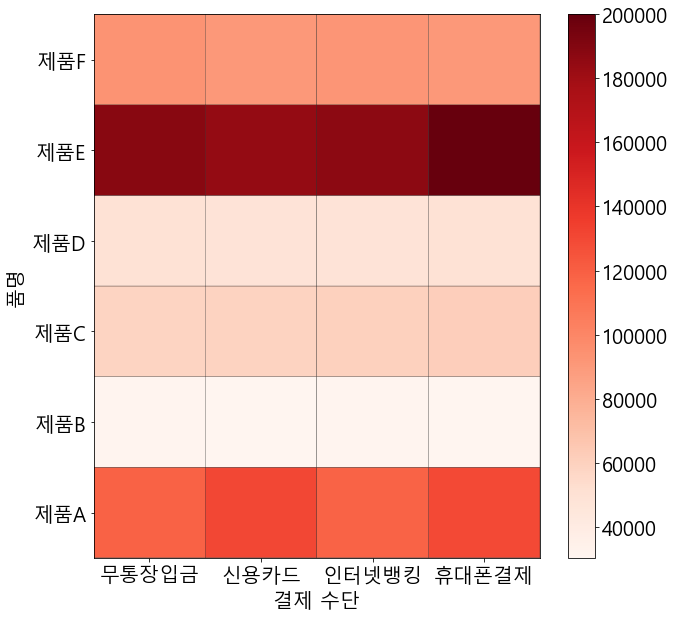

In [31]:
plt.rcParams["figure.figsize"] = (10, 10)

import numpy as np
plt.xlabel('결제 수단')
plt.ylabel('품명')

#  중간에 라벨다는게 보기 좋으므로 0.5부터 시작
plt.xticks(np.arange(0.5, len(pivot_df.columns)), pivot_df.columns)
plt.yticks(np.arange(0.5, len(pivot_df.index)), pivot_df.index)

plt.pcolor(pivot_df, edgecolors = 'black', cmap = plt.cm.Reds)
plt.colorbar()

## Step 5. 충성 고객 찾기

In [32]:
# 주문 금액 합계 기준 상위 10% 고객 찾기
grouped_df_by_customer = merged_df.groupby('주문인 ID')['주문 금액'].agg(['sum', 'count'])
grouped_df_by_customer.head()

,sum,count
주문인 ID,,
C-0,1822700.0,34
C-1,2779700.0,36
C-10,2774200.0,34
C-100,3950100.0,46
C-101,2922700.0,32


In [33]:
threshold_1 = grouped_df_by_customer['sum'].quantile(0.9) # 구매 금액 합계 기준 상위 10%
threshold_2 = grouped_df_by_customer['count'].quantile(0.9) # 구매 빈도 기준 상위 10%
print(threshold_1, threshold_2)

3506800.0 44.10000000000002


In [34]:
cond1 = grouped_df_by_customer['sum'] >= threshold_1
cond2 = grouped_df_by_customer['count'] >= threshold_2

grouped_df_by_customer.loc[cond1 & cond2].sort_values(by = ['sum', 'count'], ascending = False).head(10)

,sum,count
주문인 ID,,
C-450,4759700.0,51
C-288,4640900.0,50
C-320,4313100.0,63
C-106,4276800.0,46
C-189,4250400.0,49
C-389,4171200.0,47
C-475,4012800.0,46
C-439,3972100.0,50
C-100,3950100.0,46
